<a href="https://colab.research.google.com/github/fintechsteve/modeling-volatility/blob/master/Part_03_Modeling_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 03: Building a Modeling Framework

### In this section you will:


*   Understand the importance of creating holdback samples
*   Explore some of the challenges of setting up a performance metric for data science models in a backtesting framework.
*   Create a generalized function that can be used to provide in- and out-of-sample performance metrics


## Import all necessary libraries

For this piece, we will need the following packages to be available to our environment:

*   Numpy and Pandas (For data manipulation)
*   DateTime (For basic date manipulation)
*   Matplotlib (For timeseries vizualization)

If the packages are not available, install the with "pip install X"

In [1]:
import numpy as np, pandas as pd
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Read in data from previously stored returns.pkl file



In [2]:
with open('./returns.pkl', 'rb') as f:
    returns = pickle.load(f)
    f.close()
returns.head(10)

,AUD,CAD,CHF,EUR,GBP,JPY,NOK,NZD,SEK
1975-01-02,-0.002129,-1.712061e-03,-0.009915,-0.003544,-0.005745,-0.001502,-0.003299,0.000536,-0.004704
1975-01-03,-0.000947,1.517425e-05,0.008500,0.007886,0.003424,0.002711,0.008801,-0.001924,0.007113
1975-01-06,-0.001158,6.677374e-04,-0.001023,0.008174,0.002346,-0.004728,0.002759,-0.001129,0.009237
1975-01-07,0.004193,-1.726304e-03,0.001702,0.002150,0.001702,0.002410,0.005434,0.004567,-0.001466
1975-01-08,-0.001489,-2.000930e-04,-0.015237,-0.008650,-0.001997,0.000122,-0.006315,-0.000034,-0.006188
1975-01-09,-0.000324,-3.120108e-03,0.000298,0.004764,0.000298,-0.000409,-0.000114,-0.001217,-0.000751
1975-01-10,0.000077,-1.283429e-03,0.001489,0.001489,0.001489,0.000075,0.006256,0.000311,0.001489
1975-01-13,0.000579,-3.152212e-07,0.001789,-0.001210,0.000127,-0.000578,0.000542,0.000969,-0.002488
1975-01-14,-0.000699,7.303998e-04,-0.005132,-0.006698,-0.001827,0.000291,-0.006558,-0.000762,-0.007795
1975-01-15,-0.000934,1.198868e-03,-0.002078,0.001797,-0.000426,-0.002542,-0.002276,-0.000594,0.000094


### The importance of creating a holdback sample

When conducting data science around model building, it is important to understand the role that time plays in your modeling.

All estimation must be done using historical data. Inferences that arise from "forward looking" data can bias our understanding and the model decision making process, so it is important that we exclude them from calculations.

Unfortunately, we are not always clear about the ways in which "forward looking" can enter our modeling process and some disciplines are notoriously lax in their approach. The following "forward looking" data should be carefully controlled:

1.   Back-casting signals and model weights over the period used for estimation (in-sample). While the performance in this sample can be a useful gut check, it is dangerous to place too much weight on these insights.

2.   Data alignment and computational lag. If you run a model using data that goes through 5pm ET on a particular day, you probably can't implement a signal based on this until close of business the following day. If the data takes longer to reach your system (e.g. arrives with a 1 day processing lag) your effective lag may be longer. Performance between the date the model data is labeled and the earliest date a trade could be implemented should not be included in out-of-sample performance.

3.   Data used for macro-parameter or hyper-parameter settings. This is where most financial data scientists get themselves into trouble. If you change the parameters for an estimation window or maximum number of lags in a model using some kind of objective critereon (be it error related, e.g. RMSE, AIC or performance related, e.g. mean return, sharpe ratio, information ratio), you cannot truly count the performance over the period used to make this decision as in-sample.

   This becomes particularly problematic if you use the entire sample to reparameterize your model (e.g. because you found that the original parameterization did not work).



## Best practice for backtesting

Proper discipline around backtesting is critical and difficult to do right. At a minimum you should:

* Create a holdback period and only look at performance during this period once you are confident you have finished changing parameters on your model.
* Determine the method of evaluating your model and what you will do if your out-of-sample performance fails to meet the in-sample performance.
* Parameterize your model using a subset of the non holdback period of data. Ideally use cross-validation methods to minimize overfitting.

Ideally you should also test your model on different out of sample periods, subsamples of securities, etc to determine the robustness of your solution. However, there is an art to doing this in such a way that your testing does not influence or induce further model tweaking.

## Creating a generic model and testing framework

To help us understand our testing framework, lets create a generic model and a separate function that allows us to evaluate the performance of a model.

We can think of a model as a function that takes in a set of input data, a set of parameters and produces a set of model weights.

In the case of this example, the model weights represent be the fraction of exposure we maintain to the DXY basket (vs simply remaining hedged in our base USD currency).

Input data are the currency returns matrix. And finally parameters include:

1) Model parameters such as lookback windows for averaging, lag structure for timeseries estimators (such as maximum number of lags on AR and MA processes).
2) Hyperparameters, such as the window over which parameter estimation vs cross-validation is done, parameters for turning signals into weights, etc.
3) Modeling framework parameters, such as the extent of the holdback parameter and any framework driven constraints on the output (e.g. rescaling out of sample weights to be forced to be uniformly distributed ex post).


## A random model with a fixed seed

To test our framework, let's create a model that generates random weights regardless of the input data and parameters.

We will make the requirement that weights in-sample are uniformly distributed over [0,1] from a modeling framework perspective. However, it is easier (and better) to trust the model to do this, given our parameters.

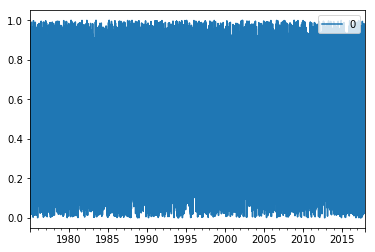

In [3]:
rets = returns
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01'}
model_params = {'seed': 1}
np.random.seed(seed=model_params['seed'])
randwts = pd.DataFrame(np.random.rand(rets['AUD'].count(),1), index=rets.index)
randwts_insample = randwts[framework_params['insample_start_date']:framework_params['insample_end_date']]
randwts_insample = randwts_insample.rank()/randwts_insample.count()
randwts[framework_params['insample_start_date']:framework_params['insample_end_date']] = randwts_insample
randwts.plot()

In [4]:
def random_model(rets, model_params, framework_params):
  np.random.seed(seed=model_params['seed'])
  randwts = pd.DataFrame(np.random.rand(rets['AUD'].count(),1), index=rets.index)
  randwts_insample = randwts[framework_params['insample_start_date']:framework_params['insample_end_date']]
  randwts_insample = randwts_insample.rank()/randwts_insample.count()
  randwts[framework_params['insample_start_date']:framework_params['insample_end_date']] = randwts_insample
  return randwts


In [5]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01'}
model_params = {'seed': 1}
randwts = random_model(returns, model_params, framework_params)
randwts.head(20)

,0
1975-01-02,0.411377
1975-01-03,0.724011
1975-01-06,0.000307
1975-01-07,0.302975
1975-01-08,0.146887
1975-01-09,0.092150
1975-01-10,0.184146
1975-01-13,0.344833
1975-01-14,0.391291
1975-01-15,0.531279


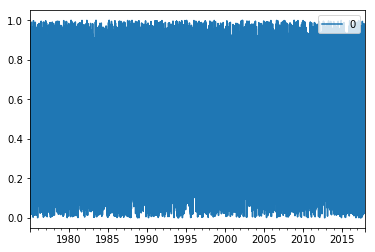

In [6]:
randwts.plot()

### Create an evaluation function that calculates the relationship between weight and subsequent DXY index volatility

The measure we are interested in is the subsequent volatility of the dxy index. For the sake of argument, we will simply use squared returns to proxy volatility (Generally currencies shouldn't have a trend if implemented using forwards to avoid interest rate differentials).

Start by calculating the dxy index again:

In [7]:
dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = pd.DataFrame(returns.dot(dxy_weight))
dxy.head(10)


,0
1975-01-02,-0.002635
1975-01-03,0.002982
1975-01-06,-0.001521
1975-01-07,0.001342
1975-01-08,-0.001337
1975-01-09,-0.000624
1975-01-10,0.000282
1975-01-13,-0.000478
1975-01-14,-0.000888
1975-01-15,-0.001446


Now create forward looking squared returns. Note that we need to decide what horizon we measure volatility over. We assume here that it is an end of day decision to hedge volatility for the next day, so a 1 day forward lookahead rule is sufficient.

In [8]:
dxy_forward = dxy.shift(-1)
dxy_forward_sq = dxy_forward**2
dxy_forward_sq.head(10)


,0
1975-01-02,8.893707e-06
1975-01-03,2.313472e-06
1975-01-06,1.800401e-06
1975-01-07,1.786578e-06
1975-01-08,3.895592e-07
1975-01-09,7.959364e-08
1975-01-10,2.284055e-07
1975-01-13,7.884330e-07
1975-01-14,2.090064e-06
1975-01-15,5.130123e-06


We need a function that measures the volatility of a strategy by multiplying our weights by the forward-looking squared returns

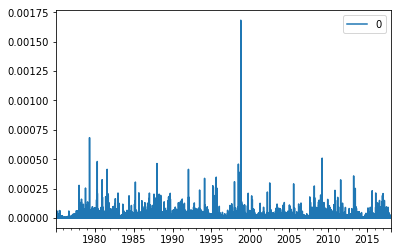

In [9]:
model_vol = randwts*dxy_forward_sq
model_vol.plot()


The problem with this is that a model biased towards zero has a lower volatility. We need a measure that takes into account the overall bias of the model and only gives credit for the ability to selectively identify periods of higher volatility. 

Note: Depending on what you are trying to measure, there is a choice to either demean over:
a) just the in sample period.
b) the whole sample.
c) the in and out of sample periods separately.

Method (b) risks introducing forward looking biases. Method (c) is appropriate if you believe that the performance out of sample will be systematically biased vs in sample. For the example below we use method (a)


In [10]:
def model_perf(model_wts, dxyfsq, framework_params):
  model_vol = (model_wts)*dxyfsq
  avgmodel_vol = np.mean(model_wts.loc[framework_params['insample_start_date']:framework_params['insample_end_date']])*dxyfsq
  is_rmse = np.sqrt(np.mean(model_vol.loc[framework_params['insample_start_date']:framework_params['insample_end_date']]))[0]
  out_rmse = np.sqrt(np.mean(model_vol.loc[framework_params['outofsample_start_date']:framework_params['outofsample_end_date']]))[0]

  is_avg_rmse = np.sqrt(np.mean(avgmodel_vol.loc[framework_params['insample_start_date']:framework_params['insample_end_date']]))[0]
  out_avg_rmse = np.sqrt(np.mean(avgmodel_vol.loc[framework_params['outofsample_start_date']:framework_params['outofsample_end_date']]))[0]

  model_perf_stats = {'insample rmse': is_rmse, 'insample excess rmse': is_rmse - is_avg_rmse,
                      'out-of-sample rmse': out_rmse, 'out-of-sample excess rmse': out_rmse - out_avg_rmse}
  return model_perf_stats

In [11]:
rets = returns
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01',
                    'outofsample_start_date': '2000-01-02',
                    'outofsample_end_date': '2017-12-26'}
model_perf_stats = model_perf(randwts, dxy_forward_sq, framework_params)
model_perf_stats

{'insample excess rmse': 2.57785452127666e-05,
 'insample rmse': 0.0034303004097798206,
 'out-of-sample excess rmse': -5.209308711301734e-05,
 'out-of-sample rmse': 0.003110624580484651}

### Exploring the properties of our performance statistics with 1,000 random models

To better understand the statistics we have created, let's iterate over 1,000 random seeds and store the model performance statistics for each iteration.

In [12]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01',
                    'outofsample_start_date': '2000-01-02',
                    'outofsample_end_date': '2017-12-26'}

def random_models_by_seed(returns, framework_params, seed):
  model_params = {'seed': seed}
  randwts = random_model(returns, model_params, framework_params)
  return model_perf(randwts, dxy_forward_sq, framework_params)

rand_perf = pd.DataFrame(list(map(lambda x:random_models_by_seed(returns, framework_params, x), range(0,1000))))

We can plot the distribution of the performance statistics. We expect that the excess RMSE should be centered around zeros - which appears to be the case.

Unsurprisingly, there is no evidence to suggest that a random model is able to predict volatility in or out of sample.

However, performing tests like this are important. They help us confirm that parts of our modeling framework are working. Given the ease of introducing coding errors, it is **vital** to do tests of the code with noise to ensure that there is no leakage of information or misinterpretation of the results from a more complex model.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1149a4be0>,
      dtype=object)

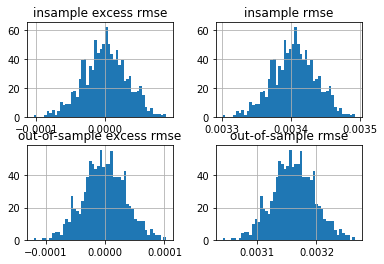

In [13]:
rand_perf.hist(bins=50)

In [14]:
rand_perf.describe()

,insample excess rmse,insample rmse,out-of-sample excess rmse,out-of-sample rmse
count,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,-1.860804e-07,0.003404,-0.000001,0.003161
std,3.123431e-05,0.000031,0.000035,0.000035
min,-1.038719e-04,0.003301,-0.000120,0.003042
25%,-2.065167e-05,0.003384,-0.000025,0.003137
50%,2.151510e-07,0.003405,-0.000002,0.003161
75%,2.086554e-05,0.003425,0.000023,0.003185
max,8.810244e-05,0.003493,0.000102,0.003265
